![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

## **Accelerating Rare Diseases Diagnosis**

**Human phenotypes**, observable traits and clinical abnormalities like “short stature” or “muscle weakness” are crucial in diagnosing diseases, especially in rare and genetic conditions.

However, these phenotypes are often buried in unstructured clinical text.

To address this, we built an **NLP Pipeline** using John Snow Labs’ Healthcare NLP & LLM library that automatically extracts phenotype mentions, determines their assertion status (e.g., present, absent, etc.), and maps them to standardized **Human Phenotype Ontology (HPO) codes**, which provides a structured vocabulary used worldwide in genomics and precision medicine.

This pipeline enables **scalable** and **accurate** phenotypic data extraction for research and clinical applications.


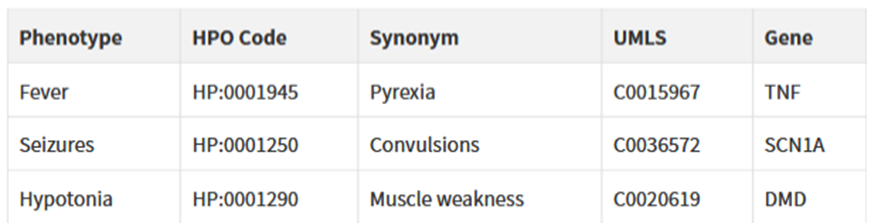

**Rare Diseases**, though individually uncommon, collectively affect a significant portion of the population. In the United States alone, over 30 million people — roughly 1 in 10 Americans — live with a rare disease. Globally, that number rises to approximately **300 million individuals**, accounting for nearly 6% of the world’s population.

There are around **7,000 identified rare diseases**, of which 80% have genetic origins, yet 95% lack an FDA-approved treatment. The burden on patients and families is immense: the average **diagnostic journey exceeds seven years**, involving visits to eight physicians and an average of **three misdiagnoses** before receiving an accurate diagnosis.

Children are particularly vulnerable — half of all rare disease patients are under 18, and **30% of affected children do not live beyond their fifth birthday**. This diagnostic and therapeutic gap underscores the urgent need for computational tools that can identify rare diseases and associated phenotypic patterns from clinical text.

In this notebook, we aim to address this challenge by **automatically extracting phenotypes** from unstructured text using NLP techniques. By doing so, we can accelerate disease recognition, support earlier diagnosis, and contribute to more personalized patient care.

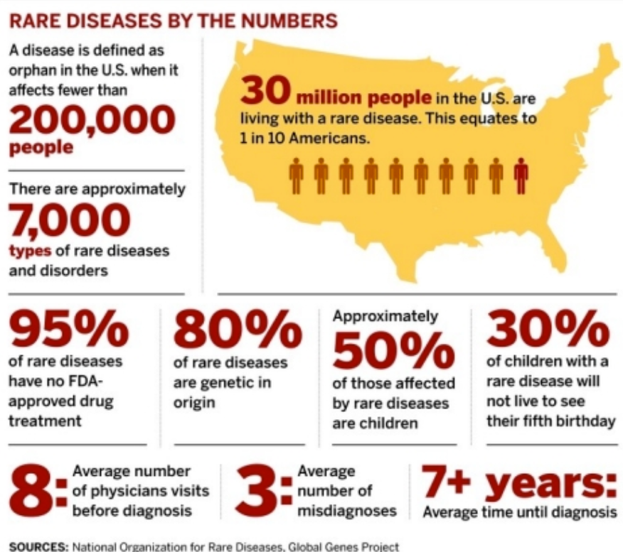

## **Setup**

In [1]:
import json
import os

from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

Saving spark_nlp_for_healthcare_spark_ocr_611.json to spark_nlp_for_healthcare_spark_ocr_611.json


In [2]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.5.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.0/737.0 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.1 MB/s eta 0:00:00


In [3]:
import json
import os

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp_jsl.pipeline_tracer import PipelineTracer
from sparknlp_jsl.pipeline_output_parser import PipelineOutputParser

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import pandas as pd
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

spark

Spark NLP Version : 6.1.3
Spark NLP_JSL Version : 6.1.1


### **Sample Text**

In [116]:
text = """
Former 32-week preterm female with respiratory distress requiring surfactant, meconium plug, abdominal distension.
Phototherapy successfully corrected the hyperbilirubinemia.
The infant had a single episode of bradycardia, with no further events observed.
There is ongoing risk for anemia of prematurity, intraventricular hemorrhage, and global developmental delay.
Yellow eye discharge was noted, though there is no evidence of conjunctivitis.
Psychosocial concerns exist due to maternal anxiety and psychiatric history.

The patient presents with locked-in syndrome secondary to stroke involving the pons.
Examination reveals preserved consciousness and preserved vertical eye movement, with tetraplegia and facial diplegia.
Communication is markedly impaired and currently limited to eye-blink coding.
"""

## **Pretrained Pipeline**

In [5]:
from sparknlp.pretrained import PretrainedPipeline

medicalpipeline = PretrainedPipeline("hpo_mapper_pipeline_v4", "en", "clinical/models")

hpo_mapper_pipeline_v4 download started this may take some time.
Approx size to download 1.7 GB
[OK!]


In [117]:
result = medicalpipeline.fullAnnotate(text)

In [118]:
result[0].keys()

dict_keys(['hpo_code', 'document', 'hpo_code_chunk', 'hpo_term', 'assertion_dl', 'hpo_2_eom', 'splits', 'token_for_splitter', 'hpo_term_raw', 'token', 'hpo_2_umls', 'hpo_2_gene_disease', 'embeddings', 'hpo_parents', 'sentence', 'hpo_synonym'])

In [119]:
result[0]['hpo_term']

[Annotation(chunk, 36, 55, respiratory distress, {'entity': 'HPO,,', 'ner_source': 'hpo_term_raw', 'chunk': '0', 'original_or_matched': 'Respiratory distress', 'sentence': '0'}, []),
 Annotation(chunk, 94, 113, abdominal distension, {'entity': 'HPO,,', 'ner_source': 'hpo_term_raw', 'chunk': '1', 'original_or_matched': 'abdominal distension', 'sentence': '0'}, []),
 Annotation(chunk, 156, 173, hyperbilirubinemia, {'entity': 'HPO,,', 'ner_source': 'hpo_term_raw', 'chunk': '2', 'original_or_matched': 'hyperbilirubinemia', 'sentence': '1'}, []),
 Annotation(chunk, 211, 221, bradycardia, {'entity': 'HPO,,', 'ner_source': 'hpo_term_raw', 'chunk': '3', 'original_or_matched': 'Bradycardia', 'sentence': '2'}, []),
 Annotation(chunk, 283, 288, anemia, {'entity': 'HPO,,', 'ner_source': 'hpo_term_raw', 'chunk': '4', 'original_or_matched': 'anemia', 'sentence': '3'}, []),
 Annotation(chunk, 306, 332, intraventricular hemorrhage, {'entity': 'HPO,,', 'ner_source': 'hpo_term_raw', 'chunk': '5', 'origi

#### **Light Pipeline**

LightPipelines are Spark NLP-specific pipeline classes that are equivalent to Spark ML Pipelines but optimized for handling smaller datasets.

- Optimized for single-machine, in-memory processing.

- Faster for small to medium datasets.

- Returns a list of dictionaries or pandas DataFrame.

- Useful for real-time predictions and prototyping.

In [120]:
import pandas as pd
chunks=[]
entities=[]
begins=[]
ends=[]

for n in result[0]['hpo_term']:

    chunks.append(n.result)
    begins.append(n.begin)
    ends.append(n.end)
    entities.append(n.metadata['entity'])

df = pd.DataFrame({'chunks':chunks, 'begin':begins, 'end':ends, 'entities':entities})

df

,chunks,begin,end,entities
0,respiratory distress,36,55,"HPO,,"
1,abdominal distension,94,113,"HPO,,"
2,hyperbilirubinemia,156,173,"HPO,,"
3,bradycardia,211,221,"HPO,,"
4,anemia,283,288,"HPO,,"
5,intraventricular hemorrhage,306,332,"HPO,,"
6,global developmental delay,339,364,"HPO,,"
7,conjunctivitis,430,443,"HPO,,"
8,anxiety,490,496,"HPO,,"
9,stroke,582,587,"HPO,,"


In [121]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(result[0], label_col='hpo_term', document_col='document', save_path="display_result_1.html")

In [122]:
hpoterm_result = []
begin = []
end = []
entity = []
assertion = []

for n, m in zip(result[0]['hpo_term'], result[0]['assertion_dl']):

    hpoterm_result.append(n.result)
    begin.append(n.begin)
    end.append(n.end)
    entity.append(n.metadata['entity'])
    assertion.append(m.result)

df_clinical = pd.DataFrame({'chunk':hpoterm_result, 'begin': begin, 'end' : end , 'label' : entity, "assertion_dl" : assertion})

df_clinical

,chunk,begin,end,label,assertion_dl
0,respiratory distress,36,55,"HPO,,",present
1,abdominal distension,94,113,"HPO,,",present
2,hyperbilirubinemia,156,173,"HPO,,",present
3,bradycardia,211,221,"HPO,,",present
4,anemia,283,288,"HPO,,",present
5,intraventricular hemorrhage,306,332,"HPO,,",present
6,global developmental delay,339,364,"HPO,,",present
7,conjunctivitis,430,443,"HPO,,",absent
8,anxiety,490,496,"HPO,,",associated_with_someone_else
9,stroke,582,587,"HPO,,",present


In [123]:
from sparknlp_display import AssertionVisualizer

vis = AssertionVisualizer()

vis.display(result[0], 'hpo_term', 'assertion_dl')

In [124]:
hpoterm_result = []
begin = []
end = []
entity = []
assertion = []
hpo_code = []

for n, m, code in zip(result[0]['hpo_term'], result[0]['assertion_dl'], result[0]['hpo_code']):
    hpoterm_result.append(n.result)
    begin.append(n.begin)
    end.append(n.end)
    entity.append(n.metadata['entity'])
    assertion.append(m.result)
    hpo_code.append(code.result)

df_clinical = pd.DataFrame({
    'chunk': hpoterm_result,
    'begin': begin,
    'end': end,
    'label': entity,
    'assertion_dl': assertion,
    'hpo_code': hpo_code
})

df_clinical

,chunk,begin,end,label,assertion_dl,hpo_code
0,respiratory distress,36,55,"HPO,,",present,HP:0002098
1,abdominal distension,94,113,"HPO,,",present,HP:0003270
2,hyperbilirubinemia,156,173,"HPO,,",present,HP:0002904
3,bradycardia,211,221,"HPO,,",present,HP:0001662
4,anemia,283,288,"HPO,,",present,HP:0001903
5,intraventricular hemorrhage,306,332,"HPO,,",present,HP:0030746
6,global developmental delay,339,364,"HPO,,",present,HP:0001263
7,conjunctivitis,430,443,"HPO,,",absent,HP:0000509
8,anxiety,490,496,"HPO,,",associated_with_someone_else,HP:0000739
9,stroke,582,587,"HPO,,",present,HP:0001297


#### **Transform**

In Spark NLP, after you create a pipeline and fit it on data, you use .transform() to process new data through that pipeline.

In [125]:
empty_data = spark.createDataFrame([[""]]).toDF("text")
data = spark.createDataFrame([[text]]).toDF("text")

In [126]:
result_df = medicalpipeline.transform(data)

In [127]:
flattener_df = Flattener()\
    .setInputCols("hpo_term") \
    .setExplodeSelectedFields(
        {"hpo_term": ["metadata.entity as entity",
                                             "begin as begin",
                                             "end as end",
                                             "result as result",
                                             "metadata.original_or_matched as matched"
                                ]
        }
    )

flattener_df.transform(result_df).show(n=100,truncate=False)

+------+-----+---+---------------------------+---------------------------+
|entity|begin|end|result                     |matched                    |
+------+-----+---+---------------------------+---------------------------+
|HPO,, |36   |55 |respiratory distress       |Respiratory distress       |
|HPO,, |94   |113|abdominal distension       |abdominal distension       |
|HPO,, |156  |173|hyperbilirubinemia         |hyperbilirubinemia         |
|HPO,, |211  |221|bradycardia                |Bradycardia                |
|HPO,, |283  |288|anemia                     |anemia                     |
|HPO,, |306  |332|intraventricular hemorrhage|intraventricular hemorrhage|
|HPO,, |339  |364|global developmental delay |global developmental delay |
|HPO,, |430  |443|conjunctivitis             |conjunctivitis             |
|HPO,, |490  |496|anxiety                    |anxiety                    |
|HPO,, |582  |587|stroke                     |stroke                     |
|HPO,, |695  |705|tetrapl

##### **HPO Code**

Mapping extracted phenotype entities from clinical or biomedical text to their corresponding Human Phenotype Ontology (HPO) codes.

Observed symptoms, signs, and clinical abnormalities are standardized using HPO terminology.

In [128]:
flattener_df = Flattener()\
    .setInputCols("hpo_code") \
     .setExplodeSelectedFields(
         {"hpo_code": ["metadata.target_text as ner_chunk",
                                              "begin as begin",
                                              "end as end",
                                              "result as HPO codes",
                                 ]
         }
     )

flattener_df.transform(result_df).show(n=100,truncate=False)

+---------------------------+-----+---+----------+
|ner_chunk                  |begin|end|HPO codes |
+---------------------------+-----+---+----------+
|respiratory distress       |36   |55 |HP:0002098|
|abdominal distension       |94   |113|HP:0003270|
|hyperbilirubinemia         |156  |173|HP:0002904|
|bradycardia                |211  |221|HP:0001662|
|anemia                     |283  |288|HP:0001903|
|intraventricular hemorrhage|306  |332|HP:0030746|
|global developmental delay |339  |364|HP:0001263|
|conjunctivitis             |430  |443|HP:0000509|
|anxiety                    |490  |496|HP:0000739|
|stroke                     |582  |587|HP:0001297|
|tetraplegia                |695  |705|HP:0002445|
|facial diplegia            |711  |725|HP:0001349|
+---------------------------+-----+---+----------+



##### **Assertion**

Assign assertion status to clinical entities extracted based on their context in the text.

In [129]:
flattener_df = Flattener()\
    .setInputCols("assertion_dl") \
    .setExplodeSelectedFields(
        {"assertion_dl": ["metadata.ner_chunk as ner_chunk",
                                             "begin as begin",
                                             "end as end",
                                             "result as assertion status",
                                             "metadata.confidence as confidence "
                                ]
        }
    )

flattener_df.transform(result_df).show(n=100,truncate=False)

+---------------------------+-----+---+----------------------------+----------+
|ner_chunk                  |begin|end|assertion status            |confidence|
+---------------------------+-----+---+----------------------------+----------+
|respiratory distress       |36   |55 |present                     |1.0       |
|abdominal distension       |94   |113|present                     |0.9995    |
|hyperbilirubinemia         |156  |173|present                     |0.9585    |
|bradycardia                |211  |221|present                     |0.9988    |
|anemia                     |283  |288|present                     |0.9996    |
|intraventricular hemorrhage|306  |332|present                     |0.9978    |
|global developmental delay |339  |364|present                     |0.9998    |
|conjunctivitis             |430  |443|absent                      |0.9994    |
|anxiety                    |490  |496|associated_with_someone_else|0.8622    |
|stroke                     |582  |587|p

##### **Synonym Mapping**

Mapping HPO terms to their exact, related, and broad synonyms, enabling standardized recognition and linking of phenotypic concepts across clinical and biomedical text.

In [130]:
flattener_df = Flattener()\
    .setInputCols("hpo_synonym") \
     .setExplodeSelectedFields(
         {"hpo_synonym": ["metadata.entity as entity",
                                              "begin as begin",
                                              "end as end",
                                              "result as result",
                                              "metadata.original_or_matched as matched"
                                 ]
         }
     )

flattener_df.transform(result_df).show(n=100,truncate=150)

+------+-----+---+------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------+
|entity|begin|end|                                                                                                                                                result|                    matched|
+------+-----+---+------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------+
| HPO,,|   36| 55|{'exact_synonym': ['breathing difficulties', 'labored breathing', 'laboured breathing', 'respiratory difficulties'], 'related_synonym': [], 'broad_...|       Respiratory distress|
| HPO,,|   94|113|{'exact_synonym': ['abdominal distention', 'abdominal bloating', 'abdominal swelling', 'belly bloating', 'bloating', 'distended abdomen'], 'related...|       abdominal distension|
| HPO,,|  

##### **Parents**

Mapping extracted phenotype entity codes to their corresponding parent terms in the Human Phenotype Ontology (HPO).

In [132]:
flattener_df = Flattener()\
    .setInputCols("hpo_parents") \
     .setExplodeSelectedFields(
         {"hpo_parents": ["metadata.entity as entity",
                                              "begin as begin",
                                              "end as end",
                                              "result as result",
                                              "metadata.original_or_matched as matched"
                                 ]
         }
     )

flattener_df.transform(result_df).show(n=100,truncate=200)

+------+-----+---+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------+
|entity|begin|end|                                                                                                                                                                                                  result|                    matched|
+------+-----+---+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------+
| HPO,,|   36| 55|HP:0002094: Dyspnea ## Difficult or labored breathing. Dyspnea is a subjective feeling only the patient can rate, e.g., on a Borg scale. => HP:0002793: Abnormal pattern of respiration ## An anomaly...|       Respiratory distress|
| HPO,,|

##### **UMLS Mapping**

Mapping HPO codes to corresponding UMLS codes.

Also returns all the possible UMLS codes in the all_k_resolutions in the metadata.

In [133]:
flattener_df = Flattener()\
    .setInputCols("hpo_2_umls") \
     .setExplodeSelectedFields(
         {"hpo_2_umls": ["metadata.entity as entity",
                                              "begin as begin",
                                              "end as end",
                                              "result as result",
                                              "metadata.original_or_matched as matched",
                                              "metadata.all_k_resolutions as all resolutions"
                                 ]
         }
     )

flattener_df.transform(result_df).show(n=100,truncate=False)

+------+-----+---+--------+---------------------------+-------------------------------------------------------------------------------------+
|entity|begin|end|result  |matched                    |all resolutions                                                                      |
+------+-----+---+--------+---------------------------+-------------------------------------------------------------------------------------+
|HPO,, |36   |55 |NONE    |Respiratory distress       |HP:0002098:::                                                                        |
|HPO,, |94   |113|C1291077|abdominal distension       |C1291077:::C0000731:::C0235698:::C0000734:::C0235318                                 |
|HPO,, |156  |173|C1142335|hyperbilirubinemia         |C1142335:::C1142015:::C0311468:::C0020433:::C0859062                                 |
|HPO,, |211  |221|C0428977|Bradycardia                |C0428977:::C0410919:::C1112488:::C0745499:::C0232191                                 |
|HPO,,

##### **Gene & Disease Mapping**

Mapping HPO codes to their associated genes and further mapping those genes to related diseases.

In [134]:
flattener_df = Flattener()\
    .setInputCols("hpo_2_gene_disease") \
     .setExplodeSelectedFields(
         {"hpo_2_gene_disease": ["metadata.entity as entity",
                                              "begin as begin",
                                              "end as end",
                                              "result as Genes and Diseases",
                                              "metadata.original_or_matched as matched"
                                 ]
         }
     )

flattener_df.transform(result_df).show(n=100,truncate=150)

+------+-----+---+------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------+
|entity|begin|end|                                                                                                                                    Genes and Diseases|                    matched|
+------+-----+---+------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------+
| HPO,,|   36| 55|{"ABCA3": ["honeycomb lung", "ground-glass opacification", "nonspecific interstitial pneumonia", "bronchial wall thickening", "sepsis", "clubbing",...|       Respiratory distress|
| HPO,,|   94|113|{"ACTG2": ["arachnodactyly", "sepsis", "gastroparesis", "intestinal malrotation", "hepatic failure", "vesicoureteral reflux", "hydroureter", "joint...|       abdominal distension|
| HPO,,|  

##### **EOM Mapping**

Mapping HPO codes to their related extraocular movements (EOM).

In [135]:
flattener_df = Flattener()\
    .setInputCols("hpo_2_eom")

flattener_df.transform(result_df).show(n=100,truncate=150)

+----------------+---------------+-------------+------------------------+------------------------------+---------------------------+----------------------------------+----------------------------------------+------------------------------------+------------------------------+-----------------------------+----------------------+--------------------------------+--------------------------------------+-------------------------+--------------------------------+---------------------------+---------------------------+------------------------------------+
|hpo_2_eom_result|hpo_2_eom_begin|hpo_2_eom_end|hpo_2_eom_metadata_chunk|hpo_2_eom_metadata___trained__|hpo_2_eom_metadata_relation|hpo_2_eom_metadata_all_k_distances|hpo_2_eom_metadata___distance_function__|hpo_2_eom_metadata_all_k_resolutions|hpo_2_eom_metadata_target_text|hpo_2_eom_metadata_ner_source|hpo_2_eom_metadata_ops|hpo_2_eom_metadata_all_relations|hpo_2_eom_metadata_original_or_matched|hpo_2_eom_metadata_entity|hpo_2_eom_metadata_

### **Clinphen Library**

[**Link**](https://pypi.org/project/clinphen/)

In [30]:
!pip install clinphen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for clinphen: filename=clinphen-1.28-py3-none-any.whl size=1977660 sha256=496dd73730fb1c2f3577174cacef8123bf2ccc713effaa8f8e98e82109931ba5
  Stored in directory: /root/.cache/pip/wheels/05/33/6d/acac30b80b89c98bea81785dea7cad510e8b00ee51e2b8e0cc
Successfully built clinphen


In [136]:
import subprocess

note = """During the clinical evaluation, the patient exhibited fused nails and teeth, a finding consistent with a rare congenital syndrome affecting ectodermal structures."""

with open("note.txt", "w") as f:
    f.write(note)

results = subprocess.run(["clinphen", "note.txt"], capture_output=True, text=True)

print(results.stdout)

HPO ID	Phenotype name	No. occurrences	Earliness (lower = earlier)	Example sentence
HP:0011312	Fused nails	1	1	during the clinical evaluation the patient exhibited fused nails and teeth a finding consistent with a rare congenital syndrome affecting ectodermal structures 



In [137]:
note = """Former 32-week preterm female with respiratory distress requiring surfactant, meconium plug, abdominal distension.
Phototherapy successfully corrected the hyperbilirubinemia.
The infant had a single episode of bradycardia, with no further events observed.
There is ongoing risk for anemia of prematurity, intraventricular hemorrhage, and global developmental delay.
Yellow eye discharge was noted, though there is no evidence of conjunctivitis.
Psychosocial concerns exist due to maternal anxiety and psychiatric history.

The patient presents with locked-in syndrome secondary to stroke involving the pons.
Examination reveals preserved consciousness and preserved vertical eye movement, with tetraplegia and facial diplegia.
Communication is markedly impaired and currently limited to eye-blink coding."""

with open("note.txt", "w") as f:
    f.write(note)

results = subprocess.run(["clinphen", "note.txt"], capture_output=True, text=True)

print(results.stdout)

HPO ID	Phenotype name	No. occurrences	Earliness (lower = earlier)	Example sentence
HP:0002098	Respiratory distress	1	0	former 32 week preterm female with respiratory distress requiring surfactant meconium plug abdominal distension 
HP:0003270	Abdominal distention	1	2	former 32 week preterm female with respiratory distress requiring surfactant meconium plug abdominal distension 
HP:0002904	Hyperbilirubinemia	1	3	phototherapy successfully corrected the hyperbilirubinemia 
HP:0001903	Anemia	1	6	there is ongoing risk for anemia of prematurity intraventricular hemorrhage and global developmental delay 
HP:0030746	Intraventricular hemorrhage	1	7	there is ongoing risk for anemia of prematurity intraventricular hemorrhage and global developmental delay 
HP:0001263	Global developmental delay	1	9	there is ongoing risk for anemia of prematurity intraventricular hemorrhage and global developmental delay 
HP:0000739	Anxiety	1	13	psychosocial concerns exist due to maternal anxiety and psychiatric hi